# Intelligent Architectures (5LIL0) Assignment 2 (version 0.2)

#### Author: Alexios Balatsoukas-Stimming, License: [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/)

## Part A: Optimization of convolutional neural network using quantization and pruning

In this notebook, you will first implement and train a convolutional neural network (CNN) for the MNIST dataset using PyTorch. Then, you will learn how to optimize this neural network using quantization and pruning.

Let us first import the required packages and the dataset, as in the previous assignment. Note that we use the ``transforms`` class from the ``torchvision`` package to normalize the dataset, instead of doing it manually.

In [90]:
import os 
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["MKL_CBWR"] = "COMPATIBLE"

# Load packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.ao.quantization as quantize
import torch.nn.utils.prune as prune
from torchvision import datasets, transforms 
import timeit
torch.manual_seed(0)

# Load and normalize the dataset
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0, 1)
    ])
mnist_train_set = datasets.MNIST('data', train=True, download = True, transform=transform)
mnist_test_set = datasets.MNIST('data', train=False, download = True, transform=transform)
mnist_train_set = list(mnist_train_set)
mnist_test_set = list(mnist_test_set)

## 1. A simple CNN for the MNIST dataset

### 1.1 Define the CNN architecture

To define a CNN, we use [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) that implements the typical convolutional layer we have discussed in the lectures. Here, we use a simple CNN with one convolutional layer with a single input channel of size ``28``×``28`` and with ``out_chans`` output channels (whose size depends on the filter size, the stride, and the padding). The convolutional layer is followed by a maxpooling layer with filter size ``maxpool_size`` and a fully connected layer with ``10`` outputs. The convolutional and fully connected layers are initialized with uniformly distributed random numbers by default.

First, we define a helper function to calculate the output size of a convolutional layer with a given input size, filter size, stride, and padding.

In [91]:
def calc_output_size(input_size,filter_size,stride,padding):
    output_size = ((input_size + 2 * padding - filter_size) / stride) + 1
    return int(output_size)

The max pooling layer output size ``max_pool_size`` can be calculated in the same way as for a convolutional layer by setting the input size equal to the output size of the previous convolutional layer (i.e., ``conv_out_size``, which also needs to be calculated), the stride equal to the filter size, and the padding to zero. The total number of features after max pooling is``out_chans``×``maxpool_out_size``×``maxpool_out_size``, so the fully connected layer that follows it needs to have that number of input neurons. Moreover, the tensor that is output by the convolutional layer has dimensions ``out_chans``×``out_size``×``out_size`` (per batch), but the fully connected layer expects a tensor if dimensions ``1``×``out_chans``×``out_size``×``out_size`` so we need to use the ``reshape`` method to reshape the tensor before feeding it into the fully connected layer.

**Note:** you can ignore all commands containing the "quant" keyword, these will be used later for quantization.

In [92]:
class MNISTCNN(nn.Module):
    def __init__(self,out_chans,filter_size,stride,padding,maxpool_size,quant_flag=False):
        super(MNISTCNN, self).__init__()
        # Define sizes
        in_size = 28
        self.out_chans = out_chans
        self.quant_flag = quant_flag
        # Calculate the size of the convolutional and maxpool layers (use int() to cast to an integer)
        self.conv_out_size = calc_output_size(in_size,filter_size,stride,padding)
        self.maxpool_out_size = calc_output_size(self.conv_out_size,maxpool_size,stride,0)
        # Define the layers
        # reshape demension (out_chans, out_size, out_size) -> (1, out_chans, out_size, out_size)
        self.conv = nn.Conv2d(1, out_chans, filter_size, stride, padding)
        self.maxpool = nn.MaxPool2d(maxpool_size)
        self.fc = nn.Linear(int(out_chans*self.maxpool_out_size*self.maxpool_out_size), 10)
        if self.quant_flag:
            self.quant = quantize.QuantStub()
            self.dequant = quantize.DeQuantStub()
    def forward(self, x):
        if self.quant_flag:
            x = self.quant(x)
        x = self.conv(x)
        x = torch.relu(x)
        x = self.maxpool(x)
        # 784?
        x = x.reshape(-1, int(self.out_chans*self.maxpool_out_size*self.maxpool_out_size))
        x = self.fc(x)
        if self.quant_flag:
            x = self.dequant(x)
        return x

# Instantiate CNN
out_chans = 16
filter_size = 3
stride = 2
padding = 1
maxpool_size = 2
model = MNISTCNN(out_chans,filter_size,stride,padding,maxpool_size,quant_flag=False)
print(f"Your convolutional layer output size is {model.conv_out_size}")
print(f"Correct convolutional layer output size is 14")
print(f"Your maxpool layer output size is {model.maxpool_out_size}")
print(f"Correct maxpool layer output size is 7")

Your convolutional layer output size is 14
Correct convolutional layer output size is 14
Your maxpool layer output size is 7
Correct maxpool layer output size is 7


### 1.2 Train the CNN

As in the previous assignment, we first define the training function and an accuracy function.

In [96]:

def train(model,train_loader,test_loader,criterion,optimizer,batch_size,num_epochs,log):

    for epoch in range(num_epochs):
        # Clean-up step for each epoch
        accuracy_train = 0
        accuracy_test  = 0

        # Forward pass, loss, backward pass, and gradient descent step
        model.train()
        for _, (imgs, labels) in enumerate(train_loader):
            out = model(imgs)             
            loss = criterion(out, labels) 
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()   
            _, preds = torch.max(out.data, 1) # get the index of the max log-probability 
            accuracy_train += (preds== labels).sum().item()/labels.shape[0]/len(train_loader)

        # Calculate test set accuracy
        model.eval()
        for _, (imgs_test, labels_test) in enumerate(test_loader):
            out_test = model(imgs_test)
            _, preds = torch.max(out_test.data, 1) # get the index of the max log-probability 
            accuracy_test += (preds== labels_test).sum().item()/labels_test.shape[0]/len(test_loader)

        if(log):
            print(f"Epoch {epoch+1}: train_acc = {accuracy_train:.3f} | test_acc = {accuracy_test:.3f}" )


'''
def train(model, train_loader, test_loader, criterion, optimizer, batch_size, num_epochs, log):
    # Set device to GPU if available
    device = torch.device("cuda")

    # Move model to GPU
    model = model.to(device)

    for epoch in range(num_epochs):
        # Clean-up step for each epoch
        accuracy_train = 0
        accuracy_test = 0

        # Forward pass, loss, backward pass, and gradient descent step
        model.train()
        for _, (imgs, labels) in enumerate(train_loader):
            # Move data to GPU
            imgs, labels = imgs.to(device), labels.to(device)

            # Forward pass
            out = model(imgs)
            loss = criterion(out, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Calculate accuracy
            _, preds = torch.max(out.data, 1)
            accuracy_train += (preds == labels).sum().item() / labels.shape[0] / len(train_loader)

        # Calculate test set accuracy
        model.eval()
        with torch.no_grad():
            for _, (imgs_test, labels_test) in enumerate(test_loader):
                # Move test data to GPU
                imgs_test, labels_test = imgs_test.to(device), labels_test.to(device)

                # Forward pass
                out_test = model(imgs_test)
                _, preds = torch.max(out_test.data, 1)
                accuracy_test += (preds == labels_test).sum().item() / labels_test.shape[0] / len(test_loader)

        if log:
            print(f"Epoch {epoch + 1}: train_acc = {accuracy_train:.3f} | test_acc = {accuracy_test:.3f}")
'''

def accuracy(model,loader):
    accuracy = 0
    for _, (imgs, labels) in enumerate(loader):    
        out = model(imgs)
        _, preds = torch.max(out.data, 1) # get the index of the max log-probability 
        accuracy += (preds== labels).sum().item()/labels.shape[0]/len(loader)
    return accuracy

Then, we instantiate and train the CNN using the Adam optimizer with ``lr=0.002`` and a cross-entropy loss function.

In [7]:
print(torch.__version__)
print(torch.version.cuda)

2.5.1
11.8


In [94]:
torch.manual_seed(0)

# Instantiate CNN
out_chans = 16
filter_size = 3
stride = 2
padding = 1
maxpool_size = 2
model = MNISTCNN(out_chans,filter_size,stride,padding,maxpool_size,quant_flag=False)
# Initialize hyperparameters
torch.manual_seed(0)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
batch_size = 128
num_epochs = 10
log=True

# Dataset loaders
train_loader = torch.utils.data.DataLoader(mnist_train_set, batch_size=batch_size,shuffle=True)
test_loader  = torch.utils.data.DataLoader(mnist_test_set, batch_size=batch_size)

# Run training
train(model,train_loader,test_loader,criterion,optimizer,batch_size,num_epochs,log)

print(f"Indicative test set accuracy after 10 epochs: 0.975")

Epoch 1: train_acc = 0.880 | test_acc = 0.943
Epoch 2: train_acc = 0.951 | test_acc = 0.962
Epoch 3: train_acc = 0.965 | test_acc = 0.967
Epoch 4: train_acc = 0.969 | test_acc = 0.968
Epoch 5: train_acc = 0.972 | test_acc = 0.971
Epoch 6: train_acc = 0.974 | test_acc = 0.971
Epoch 7: train_acc = 0.976 | test_acc = 0.974
Epoch 8: train_acc = 0.976 | test_acc = 0.973
Epoch 9: train_acc = 0.978 | test_acc = 0.975
Epoch 10: train_acc = 0.979 | test_acc = 0.975
Indicative test set accuracy after 10 epochs: 0.975


## 2. Quantization

### 2.1 Post-training quantization (PTQ)

We will now apply post-training quantization to the model trained in the previous section. First, we need to re-instantiate our model to explicitly state where quantization and de-quantization will take place using ``QuantStub()`` and ``DeQuantStub()`` in the original definition of the ``MNISTCNN`` class, even though no quantization takes place yet. In this example, we want the input image to be quantized, all operations to be carried out with quantized values, and then the output can be dequantized. Then, we copy the previously trained weights to this new model to avoid re-training.

In [97]:
# Re-instantiate CNN
out_chans = 16
filter_size = 3
stride = 2
padding = 1
maxpool_size = 2        
model_fp = MNISTCNN(out_chans,filter_size,stride,padding,maxpool_size,quant_flag=True)

# Copy weights from previously trained model
model_fp.load_state_dict(model.state_dict())

# Calculate accuracy of floating-point model on test set
accuracy_fp = accuracy(model_fp,test_loader)

The next step is to define the type of quantization we want using a ``QConfig`` object. The quantization can be configured separately for activations and for weights, which is useful when using ReLU-type activations since they are aways non-negative while weights can generally take on any real value. We will use a ``MinMaxObserver`` that collects statistics for the minimum and maximum values and the default per-tensor asymmetric quantization (i.e., ``qscheme=per_tensor_affine``), but per-channel and symmetric options are also available. Activations will be stored in 8-bit unsigned integer variables and weights will be stored in 8-bit signed integer variables. We can also simulate smaller bit-widths by setting ``quant_min`` and ``quant_max`` appropriately as a function of the bit-width variable ``bits`` (**Careful:** unsigned and signed integers have different ranges for the same bit-width!)

In [98]:
def get_quant_config_ptq(bits):
    q_config = torch.ao.quantization.QConfig(
        activation=quantize.MinMaxObserver.with_args(
                            quant_min = 0,
                            quant_max = 2**bits - 1,
                            # quant_max = 255,
                            dtype=torch.quint8),
        weight=quantize.MinMaxObserver.with_args(
                            quant_min = -2**(bits - 1) + 1,
                            quant_max = 2**(bits - 1) - 1,
                            # quant_min = -127,
                            # quant_max = 127,
                            dtype=torch.qint8),
    ) 
    return q_config

Then, we can instantiate a ``QConfig`` object for the desired bit-width, which we add to the floating-point model. We use ``prepare`` to put the floating-point model into calibration mode, and we provide a representative dataset (here we provide the entire training dataset) that PyTorch uses to calculate activation statistics since these are only known at run-time. Finally, we use ``convert`` to create the quantized model and we evaluate its accuracy on the calibration data for comparison. You will observe that with 8-bit quantization the accuracy loss is very small, but with smaller bit-widths the loss starts becoming more significant.

In [99]:
# Quantization configuration and preparation
bits = 8
model_fp.qconfig = get_quant_config_ptq(bits)
model_fp.eval() # Model needs to be in evaluation mode to collect statistics
model_fp_prepared_ptq = quantize.prepare(model_fp)

# Provide representative dataset to collect statistics
for _, (imgs, labels) in enumerate(train_loader):    
    out = model_fp_prepared_ptq(imgs)

# Quantize model and run it to obtain quantized accuracy
model_ptq = quantize.convert(model_fp_prepared_ptq)    
accuracy_ptq = accuracy(model_ptq,test_loader)

print(f"Your floating-point accuracy is {accuracy_fp:.3f} and quantized accuracy is {accuracy_ptq:.3f}")
print(f"Indicative floating-point accuracy is 0.975 and quantized accuracy is 0.961")

Your floating-point accuracy is 0.975 and quantized accuracy is 0.961
Indicative floating-point accuracy is 0.975 and quantized accuracy is 0.961


### 2.2 Quantization-aware training (QAT)

Similarly to PTQ, we need to define the quantization parameters using a ``QConfig`` object. The main difference is that we use a ``FakeQuantize`` module that simulates quantization during the training, while also keeping track of statistics with an observer object.

In [100]:
def get_quant_config_qat(bits):
    q_config = torch.ao.quantization.QConfig(
        activation=quantize.FakeQuantize.with_args(
                            observer=quantize.observer.MinMaxObserver,
                            quant_min = 0,
                            quant_max = 2**bits - 1,
                            dtype=torch.quint8),
                            # RuntimeError: getCudnnDataTypeFromScalarType() not supported for QUInt8
                            # dtype=torch.qint8),
        weight=quantize.FakeQuantize.with_args(
                            observer=quantize.observer.MinMaxObserver,
                            quant_min = -2**(bits - 1) + 1,
                            quant_max = 2**(bits - 1) - 1,
                            dtype=torch.qint8),
    ) 
    return q_config

Then, we can instantiate a ``QConfig`` object for the desired bit-width, which we add to the floating-point model. We use ``prepare_qat`` to put the floating-point model into quantization-aware training mode (note that the floating-point model needs to be in training mode). We then define the training hyperparameters as usual and run one epoch of post-training quantization (remember that the model has already been trained for five epochs previously). Finally, we quantize the model and we calculate its accuracy on the test data.

In [ ]:
'''
def train(model,train_loader,test_loader,criterion,optimizer,batch_size,num_epochs,log):

    for epoch in range(num_epochs):
        # Clean-up step for each epoch
        accuracy_train = 0
        accuracy_test  = 0

        # Forward pass, loss, backward pass, and gradient descent step
        model.train()
        for _, (imgs, labels) in enumerate(train_loader):
            out = model(imgs)             
            loss = criterion(out, labels) 
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()   
            _, preds = torch.max(out.data, 1) # get the index of the max log-probability 
            accuracy_train += (preds== labels).sum().item()/labels.shape[0]/len(train_loader)

        # Calculate test set accuracy
        model.eval()
        for _, (imgs_test, labels_test) in enumerate(test_loader):
            out_test = model(imgs_test)
            _, preds = torch.max(out_test.data, 1) # get the index of the max log-probability 
            accuracy_test += (preds== labels_test).sum().item()/labels_test.shape[0]/len(test_loader)

        if(log):
            print(f"Epoch {epoch+1}: train_acc = {accuracy_train:.3f} | test_acc = {accuracy_test:.3f}" )
'''

In [101]:
torch.manual_seed(0)

model_fp.train()
bits = 8
model_fp.qconfig = get_quant_config_qat(bits)
model_fp_prepared_qat = quantize.prepare_qat(model_fp)

# Define training hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_fp_prepared_qat.parameters(), lr=0.002)
batch_size = 128
num_epochs = 1
log=False

# Run quantization-aware training
train(model_fp_prepared_qat,train_loader,test_loader,criterion,optimizer,batch_size,num_epochs,log)

# Quantize model and run it to obtain quantized accuracy
model_fp_prepared_qat.eval()
model_qat = quantize.convert(model_fp_prepared_qat)    
accuracy_qat = accuracy(model_qat,test_loader)

print(f"Your floating-point accuracy is {accuracy_fp:.3f} and quantized accuracy is {accuracy_qat:.3f}")
print(f"Indicative floating-point accuracy is 0.975 and quantized accuracy is 0.966")

Your floating-point accuracy is 0.975 and quantized accuracy is 0.965
Indicative floating-point accuracy is 0.975 and quantized accuracy is 0.966


### 2.3 Comparison of PTQ and QAT

The difference in accuracy between PTQ and QAT in the above example is very small, although QAT still has an edge. This happens because we use 8 quantization bits, which, as you will see, is significantly more than what is required for this simple CNN. To illustrate this point, below we implement a loop that explores quantization bit-widths from 2 to 8 bits. For each run of the loop, a new quantization configuration is instantiated for PTQ and QAT, then the floating-point model is prepared using that configuration, a representative dataset is fed into the model (for PTQ) or a training iteration is performed (for QAT), and finally the corresponding models are quantized and their accuracy is evaluated on the test set and stored in a list for plotting.

Your PTQ accuracies: [0.137 0.637 0.945 0.969 0.973 0.974 0.961]
Your QAT accuracies: [0.226 0.820 0.958 0.971 0.977 0.974 0.958]
Indicative PTQ accuracies: [0.138 0.655 0.937 0.969 0.973 0.974 0.961]
Indicative QAT accuracies: [0.247 0.828 0.960 0.969 0.976 0.974 0.959]


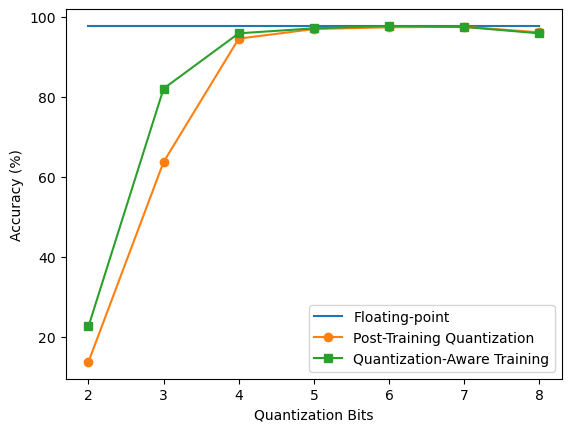

In [102]:
torch.manual_seed(0)
accuracy_ptq_list = list()
accuracy_qat_list = list()
bits_list = range(2,9)

# Training hyperparameters for QAT
criterion = nn.CrossEntropyLoss()
batch_size = 128
num_epochs = 1
log=False

for bits in bits_list:

    ### PTQ
    
    # Configure, provide representative dataset, and quantize model (multiple lines of code required)
    model_fp.qconfig = get_quant_config_ptq(bits)
    model_fp.eval() # Model needs to be in evaluation mode to collect statistics
    model_fp_prepared_ptq = quantize.prepare(model_fp)
    # Provide representative dataset to collect statistics
    for _, (imgs, labels) in enumerate(train_loader):    
        out = model_fp_prepared_ptq(imgs)
    # Quantize model and run it to obtain quantized accuracy
    model_ptq = quantize.convert(model_fp_prepared_ptq)

    accuracy_ptq_list.append(accuracy(model_ptq,test_loader))

    ### QAT

    # Configure, train, and quantize model (multiple lines of code required)
    model_fp.qconfig = get_quant_config_qat(bits)

    # AssertionError: prepare_qat only works on models in training mode
    model_fp.train()

    model_fp_prepared_qat = quantize.prepare_qat(model_fp)
    # Run quantization-aware training
    optimizer = torch.optim.Adam(model_fp_prepared_qat.parameters(), lr=0.002)

    train(model_fp_prepared_qat,train_loader,test_loader,criterion,optimizer,batch_size,num_epochs,log)

    # Quantize model and run it to obtain quantized accuracy
    model_fp_prepared_qat.eval()
    model_qat = quantize.convert(model_fp_prepared_qat)

    accuracy_qat_list.append(accuracy(model_qat,test_loader))

# Print results
print('Your PTQ accuracies: [' + ' '.join('{:.3f}'.format(acc) for i,acc in enumerate(accuracy_ptq_list)) + ']')
print('Your QAT accuracies: [' + ' '.join('{:.3f}'.format(acc) for i,acc in enumerate(accuracy_qat_list)) + ']')
print('Indicative PTQ accuracies: [0.138 0.655 0.937 0.969 0.973 0.974 0.961]')
print('Indicative QAT accuracies: [0.247 0.828 0.960 0.969 0.976 0.974 0.959]')

# Plot results
plt.plot(bits_list,100*accuracy_fp*np.ones(len(accuracy_ptq_list)))
plt.plot(bits_list,100*np.array(accuracy_ptq_list), 'o-')
plt.plot(bits_list,100*np.array(accuracy_qat_list), 's-')
plt.ylabel('Accuracy (%)')
plt.xlabel('Quantization Bits')
plt.legend(['Floating-point','Post-Training Quantization','Quantization-Aware Training'])

## 3. Pruning

PyTorch supports various types of pruning. For example, it is possible to prune each layer separately and there are various pruning methods (e.g., structured/unstructured and based on various criteria like the $L_1$-norm or the $L_2$-norm). Not all combinations are natively supported, but it is possible to write your own custom pruning method. We will use simple, albeit very effective, global pruning (i.e., all layers are pruned jointly). More specifically, the variable ``sparsity`` controls the desired sparsity factor and the individual weights with the smallest $L_1$ norm (i.e., the smallest absolute value) are removed from the model. In this example, we use ``sparsity=0.75``, which means that only 25% of the weights are kept in the model.

In [ ]:
# Re-instantiate CNN
out_chans = 16
filter_size = 3
stride = 2
padding = 1
maxpool_size = 2        
model_pruned = MNISTCNN(out_chans,filter_size,stride,padding,maxpool_size,quant_flag=False)

# ------------------------
# model_pruned.to(device)
# ------------------------

# Copy weights from previously trained model
model_pruned.load_state_dict(model.state_dict())

# Calculate accuracy on test set before pruning
accuracy_unpruned = accuracy(model,test_loader)     # 这边 accuracy(model_pruned, test_loader) 也行

# Create a list of parameters to prune
parameters_to_prune = ( (model_pruned.conv, 'weight'), (model_pruned.fc, 'weight') )

# Apply pruning
sparsity=0.75
prune.global_unstructured(parameters_to_prune,pruning_method=prune.L1Unstructured,amount=sparsity)

# Calculate per-layer and global sparsity
print("Sparsity in convolutional layer: {:.2f}%".format(100. * float(torch.sum(model_pruned.conv.weight == 0))/float(model_pruned.conv.weight.nelement())))
print("Sparsity in fully connected layer {:.2f}%".format(100. * float(torch.sum(model_pruned.fc.weight == 0))/float(model_pruned.fc.weight.nelement())))
print("Global sparsity: {:.2f}%".format(100. * float(torch.sum(model_pruned.conv.weight == 0)+torch.sum(model_pruned.fc.weight == 0))/float(model_pruned.conv.weight.nelement()+model_pruned.fc.weight.nelement())))

# Calculate accuracy on test set after pruning
accuracy_pruned = accuracy(model_pruned,test_loader)

print("The accuracy before pruning is {:.3f} and the accuracy after pruning is {:.3f}".format(accuracy_unpruned, accuracy_pruned))

Sparsity in convolutional layer: 34.03%
Sparsity in fully connected layer 75.75%
Global sparsity: 75.00%
The accuracy before pruning is 0.975 and the accuracy after pruning is 0.906


### 3.1 Fine-tuning

When pruning 75% of the weights, the accuracy dropped quite significantly to around 84%. Even though the model is still usable with that accuracy, we would ideally like to recover the lost accuracy. This can be achieved by fine-tuning the pruned model through additional training.

When a layer is pruned in PyTorch, its original ``weight`` parameter is replaced by two new parameters: ``weight_orig``, which contains the original weights before pruning, and ``weight_mask``, which contains a binary pruning mask that is point-wise multiplied with ``weight_orig`` to obtain the weights of the pruned model (i.e., the mask forces pruned weights to zero). This is convenient because we can fine-tune the model by simply running our training function, which will update the weights in ``weight_orig``, and ``weight_mask`` will ensure that the sparsity factor is unchanged. This additional information added for pruning can be removed from a layer with the ``prune.remove()`` method, but then fine-tuning will update all weights including previously pruned ones.

In [104]:
torch.manual_seed(0)
# Define training hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_pruned.parameters(), lr=0.002)
batch_size = 128
num_epochs = 1
log=False

# Fine-tune
train(model_pruned,train_loader,test_loader,criterion,optimizer,batch_size,num_epochs,log)

# Calculate accuracy on test set after fine-tuning
accuracy_pruned_finetuned = accuracy(model_pruned,test_loader)

# Print accuracies and confirm that sparsity is unchanged after training
print("Global sparsity: {:.2f}%".format(100. * float(torch.sum(model_pruned.conv.weight == 0)+torch.sum(model_pruned.fc.weight == 0))/float(model_pruned.conv.weight.nelement()+model_pruned.fc.weight.nelement())))
print("The accuracy before pruning is {:.3f}, the accuracy after pruning is {:.3f}, the accuracy after pruning and fine-tuning is {:.3f}".format(accuracy_unpruned, accuracy_pruned, accuracy_pruned_finetuned))

Global sparsity: 75.00%
The accuracy before pruning is 0.975, the accuracy after pruning is 0.906, the accuracy after pruning and fine-tuning is 0.971


### 3.2 Sparsity ratio exploration

To show the effect of the sparsity ratio, we now prune and evaluate the accuracy of the pruned model for various sparsity ratios (both with and without fine-tuning). The fine-tuned pruned model supports a sparsity ratio of up to 0.75 without any degradation in the accuracy, which means that 75% of the weights are unnecessary. Further pruning is possible at the cost of slightly reduced accuracy, and the CNN still achieves approximately 90% accuracy even with a staggering 0.95 sparsity ratio, i.e., with only 5% of the original weights! Without fine-tuning, the degradation is much more rapid.

Your pruning accuracies: [0.960 0.958 0.929 0.912 0.882 0.906 0.714 0.536 0.389 0.407]
Your pruning+finetuning accuracies: [0.976 0.974 0.975 0.974 0.973 0.972 0.966 0.957 0.933 0.820]
Indicative pruning accuracies: [0.960 0.960 0.940 0.909 0.892 0.908 0.718 0.535 0.399 0.424]
Indicative pruning+finetuning accuracies: [0.976 0.974 0.974 0.974 0.973 0.972 0.966 0.958 0.935 0.823]


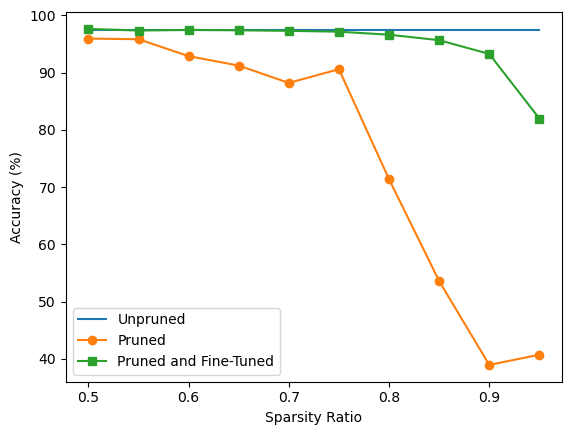

In [105]:
torch.manual_seed(0)
sparsity_list = [x / 100.0 for x in range(50, 100, 5)]
accuracy_pruned_list = list()
accuracy_pruned_finetuned_list = list()

for sparsity in sparsity_list:

    # Define model
    model_pruned = MNISTCNN(out_chans,filter_size,stride,padding,maxpool_size,quant_flag=False)
    # Copy weights from previously trained model
    model_pruned.load_state_dict(model.state_dict())

    # model_pruned = model_pruned.to(device)

    # Prune model
    # Create a list of parameters to prune
    parameters_to_prune = ( (model_pruned.conv, 'weight'), (model_pruned.fc, 'weight') )
    # Apply pruning
    prune.global_unstructured(parameters_to_prune,pruning_method=prune.L1Unstructured,amount=sparsity)

    # Append data
    accuracy_pruned = accuracy(model_pruned, test_loader)
    accuracy_pruned_list.append(accuracy_pruned)

    # Fine-tune model
    optimizer = torch.optim.Adam(model_pruned.parameters(), lr=0.002)
    train(model_pruned,train_loader,test_loader,criterion,optimizer,batch_size,num_epochs,log)

    # Append data
    accuracy_pruned_finetuned = accuracy(model_pruned, test_loader)
    accuracy_pruned_finetuned_list.append(accuracy_pruned_finetuned)

# Print results
print('Your pruning accuracies: [' + ' '.join('{:.3f}'.format(acc) for i,acc in enumerate(accuracy_pruned_list)) + ']')
print('Your pruning+finetuning accuracies: [' + ' '.join('{:.3f}'.format(acc) for i,acc in enumerate(accuracy_pruned_finetuned_list)) + ']')
print('Indicative pruning accuracies: [0.960 0.960 0.940 0.909 0.892 0.908 0.718 0.535 0.399 0.424]')
print('Indicative pruning+finetuning accuracies: [0.976 0.974 0.974 0.974 0.973 0.972 0.966 0.958 0.935 0.823]')

# Plot results
plt.plot(sparsity_list,100*accuracy_unpruned*np.ones(len(sparsity_list)))
plt.plot(sparsity_list,100*np.array(accuracy_pruned_list), 'o-')
plt.plot(sparsity_list,100*np.array(accuracy_pruned_finetuned_list), 's-')
plt.ylabel('Accuracy (%)')
plt.xlabel('Sparsity Ratio')
plt.legend(['Unpruned','Pruned','Pruned and Fine-Tuned'])

## 4. Combining Quantization and Pruning

Quantization and pruning can be combined. In the example below, we first prune our model with fine-tuning and we then quantize it using PTQ. Note that we have to use ``prune.remove`` discussed previously before quantization to remove the pruning re-parameterization as otherwise quantization will not work. Here, we choose ``sparsity=0.75`` and ``bits=6`` because these were the values that we previously saw resulted in practically no loss with respect to the un-optimized CNN when only pruning and only applying PTQ, respectively. The resulting pruned and quantized CNN also shows a very minimal accuracy loss with respect to the unoptimized CNN. In general, however, there is a complex interaction between pruning and quantization, meaning that the pruning ratio and the quantization bit-width cannot usually be optimized separately. In this script, we also calculate the average execution time for one inference for the unoptimized CNN, the pruned CNN, and the pruned and quantized CNN.

In [ ]:
'''
def accuracy(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    # Some quantized models have no parameters after convert()
    try:
        model_device = next(model.parameters()).device
    except StopIteration:
        model_device = torch.device("cpu")

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(model_device), labels.to(model_device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total
'''

In [107]:
import time
torch.manual_seed(0)

## Define model
model_pruned = MNISTCNN(out_chans,filter_size,stride,padding,maxpool_size,quant_flag=True)
model_pruned.load_state_dict(model.state_dict())

# Get accuracy and execution time of unoptimized model
start_unoptimized = timeit.default_timer()
accuracy_unoptimized = accuracy(model,test_loader)
end_unoptimized = timeit.default_timer()
runtime_unoptimized = (end_unoptimized-start_unoptimized)/len(test_loader)

## Prune floating-point model

# Prune
sparsity = 0.75
parameters_to_prune = ( (model_pruned.conv, 'weight'), (model_pruned.fc, 'weight') )
prune.global_unstructured(parameters_to_prune,pruning_method=prune.L1Unstructured,amount=sparsity)

# Fine-tune
optimizer = torch.optim.Adam(model_pruned.parameters(), lr=0.002)
train(model_pruned,train_loader,test_loader,criterion,optimizer,batch_size,num_epochs,log)                                
accuracy_pruned_finetuned = accuracy(model_pruned,test_loader)

# Remove re-parameterization
prune.remove(model_pruned.conv, name='weight')
prune.remove(model_pruned.fc, name='weight')

# Get accuracy and execution time of pruned model
start_pruned = timeit.default_timer()
accuracy_pruned = accuracy(model_pruned,test_loader)
end_pruned = timeit.default_timer()
runtime_pruned = (end_pruned-start_pruned)/len(test_loader)

## Quantize pruned model with PTQ

# Apply configuration
bits = 6
model_pruned.qconfig = get_quant_config_ptq(bits)
model_pruned_prepared_ptq = quantize.prepare(model_pruned)

# Provide representative dataset to collect statistics
for _, (imgs, labels) in enumerate(train_loader):
    # Change the devices
    # imgs = imgs.to(device)
    out = model_pruned_prepared_ptq(imgs)

# Quantize
model_pruned_ptq = quantize.convert(model_pruned_prepared_ptq)
# Put model back to CPU
# model_pruned_ptq = model_pruned_ptq.to("cpu")

# Get accuracy and execution time of pruned and quantized model
start_pruned_ptq = timeit.default_timer()

# model_pruned_ptq.to("cpu")

accuracy_pruned_ptq = accuracy(model_pruned_ptq,test_loader)
end_pruned_ptq = timeit.default_timer()
runtime_pruned_ptq = (end_pruned_ptq-start_pruned_ptq)/len(test_loader)

print("Accuracy: unoptimized {:.3f}, pruned {:.3f}, pruned and quantized {:.3f}".format(accuracy_fp,accuracy_pruned, accuracy_pruned_ptq))
print("Average per-inference runtime: unoptimized {:.2f} ms, pruned {:.2f} ms, pruned and quantized {:.2f} ms".format(runtime_unoptimized*10**3,runtime_pruned*10**3, runtime_pruned_ptq*10**3))

Accuracy: unoptimized 0.975, pruned 0.972, pruned and quantized 0.971
Average per-inference runtime: unoptimized 4.26 ms, pruned 3.74 ms, pruned and quantized 3.37 ms
